# **Brain Tumor Segmentation**

* MR image file containing a 4D array of in the shape of (240, 240, 155, 4).
    -  The first 3 dimensions are the X, Y, and Z values which is called voxel.
    -  The 4th dimension is the values for 4 different sequences
        - 0 - **FLAIR** : "Fluid Attenuated Inversion Recovery" (FLAIR)
        - 1 - **T1w** : "T1-weighted"
        - 2 - **t1gd** : "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
        - 3 - **T2w** : "T2-weighted"

* Label file containing a 3D array with the shape of (240, 240, 155).  
    - The integer values in this array indicate the "label" for each voxel in the corresponding image files:
        - 0: background
        - 1: edema
        - 2: non-enhancing tumor
        - 3: enhancing tumor

### *Import Libraries*

In [1]:
import utils
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### *Set DataGenerator*

In [2]:
X = torch.load('/content/drive/My Drive/BrainTumourData/TensorData/X.pt')
y = torch.load('/content/drive/My Drive/BrainTumourData/TensorData/y.pt')

train_loader, valid_loader = utils.DataGenerator(X, y, batch_size=8, valid_size=0.3)

In [3]:
print(len(train_loader.sampler))
print(len(valid_loader.sampler))

122
51


In [4]:
#dataiter = iter(train_loader)
#images,labels = dataiter.next()
#print(type(images))
#print(images.shape)
#print(labels.shape)

### *Create Model*

In [5]:
def conv_block(in_chan, out_chan, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.Conv3d(in_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_chan),
            nn.ReLU(inplace=True))
    else:
        return nn.Sequential(
            nn.Conv3d(in_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_chan))

In [6]:
class Unet3D(nn.Module):

    def __init__(self, in_chan, out_chan, filters):
        super(Unet3D, self).__init__()

        self.in_chan = in_chan
        self.out_chan = out_chan
        self.filters = filters

        # Encoder
        self.conv_1 = conv_block(self.in_chan, self.filters * 1)
        self.conv_2 = conv_block(self.filters * 1, self.filters * 2)
        self.conv_3 = conv_block(self.filters * 2, self.filters * 4)

        self.conv_1_1 = conv_block(filters * 1, filters * 1)
        self.conv_2_1 = conv_block(filters * 2, filters * 2)
        self.conv_3_1 = conv_block(filters * 4, filters * 4)

        self.max_pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottel-neck
        self.bottel_neck = conv_block(self.filters * 4, self.filters * 8)
        self.dropout = nn.Dropout3d(0.3)

        # Decoder
        self.upsample = nn.Upsample(scale_factor=(2.0, 2.0, 2.0), mode='nearest')
        self.dconv_1 = conv_block(self.filters * 12, self.filters * 4)
        self.dconv_2 = conv_block(self.filters * 6, self.filters * 2)
        self.dconv_3 = conv_block(self.filters * 3, self.filters * 1)

        # Output and Conv_block
        self.output = conv_block(self.filters * 1, self.out_chan, final_layer=True)

    def forward(self, x):

        # Down Sampling
        conv1 = self.conv_1_1(self.conv_1(x))                                         # (:, 16, :, :, :)
        conv2 = self.conv_2_1(self.conv_2(self.max_pool(conv1)))                      # (:, 32, :, :, :)
        conv3 = self.conv_3_1(self.conv_3(self.dropout(self.max_pool(conv2))))        # (:, 64, :, :, :)

        # Bottel-neck
        bottelneck = self.bottel_neck(self.max_pool(conv3))                           # (:, 128, :, :, :)

        # Up Sampling
        upconv1 = self.upsample(bottelneck)                                           # (:, 128, :, :, :)
        upconv1 = torch.cat([upconv1, conv3], dim=1)                                  # (:, 192, :, :, :)
        upconv1 = self.dconv_1(upconv1)                                               # (:, 64, :, :, :)

        upconv2 = self.upsample(upconv1)                                              # (:, 64, :, :, :)
        upconv2 = torch.cat([upconv2, conv2], dim=1)                                  # (:, 96, :, :, :)
        upconv2 = self.dconv_2(self.dropout(upconv2))                                 # (:, 32, :, :, :)

        upconv3 = self.upsample(upconv2)                                              # (:, 32, :, :, :)
        upconv3 = torch.cat([upconv3, conv1], dim=1)                                  # (:, 48, :, :, :)
        upconv3 = self.dconv_3(upconv3)                                               # (:, 16, :, :, :)

        out = F.logsigmoid(self.output(upconv3))                                      # (:, 3, :, :, :)

        return out

In [7]:
model = Unet3D(in_chan=4, out_chan=3, filters=16)
model.to(device)

Unet3D(
  (conv_1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_1_1): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_2_1): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), st

### *Loss and Optimizer*

In [8]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    dice_numerator = (2.0 * torch.sum(y_pred * y_true, axis=axis)) + epsilon
    dice_denominator = torch.sum(y_pred, dim=axis) + torch.sum(y_true, dim=axis) + epsilon
    dice_coefficient = torch.mean(dice_numerator / dice_denominator)
    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    dice_numerator = (2.0 * torch.sum(y_pred * y_true, axis=axis)) + epsilon
    dice_denominator = torch.sum(y_pred**2, dim=axis) + torch.sum(y_true**2, dim=axis) + epsilon
    dice_loss = 1 - torch.mean(dice_numerator / dice_denominator)
    return dice_loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

### *Training*

In [10]:
epochs = 100
hist_train_loss = []
hist_val_loss = []

hist_train_dice = []
hist_val_dice = []

valid_loss_min = np.Inf

In [11]:
for epoch in range(epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_dice = 0.0
    val_dice = 0.0

    model.train()
    for images,labels in train_loader:

        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        logps = model(images)
        ps = torch.exp(logps)

        dice = dice_coefficient(labels, ps)
        loss = soft_dice_loss(labels, ps)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_dice += dice.item()*images.size(0)
        
    model.eval()
    with torch.no_grad():
        for images,labels in valid_loader:

            images = images.cuda()
            labels = labels.cuda()

            logps = model(images)
            ps = torch.exp(logps)

            dice = dice_coefficient(labels, ps)
            loss = soft_dice_loss(labels,ps)        
            val_loss += loss.item()*images.size(0)
            val_dice += dice.item()*images.size(0)
    
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    train_dice = train_dice / len(train_loader.sampler)
    val_dice = val_dice / len(valid_loader.sampler)

    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_train_dice.append(train_dice)
    hist_val_dice.append(val_dice)

    print("\nEpoch : {} \ntraining Loss : {:.6f}, \tTrain_dice : {:.6f}, \nValidation Loss : {:.6f}, \tVal_dice : {:.6f}".format(epoch + 1, 
                                                                                                                    train_loss, train_dice,
                                                                                                                    val_loss, val_dice))
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).\nSaving model ...'.format(valid_loss_min,val_loss))
        torch.save(model.state_dict(), 'TumorSegmentation.pt')
        valid_loss_min = val_loss


Epoch : 1 
training Loss : 0.831165, 	Train_dice : 0.091307, 
Validation Loss : 0.947216, 	Val_dice : 0.052331
Validation loss decreased (inf --> 0.947216).
Saving model ...

Epoch : 2 
training Loss : 0.782091, 	Train_dice : 0.114103, 
Validation Loss : 0.857517, 	Val_dice : 0.094348
Validation loss decreased (0.947216 --> 0.857517).
Saving model ...

Epoch : 3 
training Loss : 0.742513, 	Train_dice : 0.127446, 
Validation Loss : 0.808564, 	Val_dice : 0.109255
Validation loss decreased (0.857517 --> 0.808564).
Saving model ...

Epoch : 4 
training Loss : 0.695042, 	Train_dice : 0.141093, 
Validation Loss : 0.678194, 	Val_dice : 0.139173
Validation loss decreased (0.808564 --> 0.678194).
Saving model ...

Epoch : 5 
training Loss : 0.648803, 	Train_dice : 0.157133, 
Validation Loss : 0.687640, 	Val_dice : 0.115175

Epoch : 6 
training Loss : 0.604209, 	Train_dice : 0.173692, 
Validation Loss : 0.633790, 	Val_dice : 0.164193
Validation loss decreased (0.678194 --> 0.633790).
Saving mod

### *Prediction Visualization*

In [19]:
pred_y = model(torch.unsqueeze(X[55].cuda(), 0))
pred_y = torch.exp(pred_y)
pred_y.shape

torch.Size([1, 3, 160, 160, 16])

In [20]:
pred_y = torch.squeeze(pred_y, 0)
pred_y = pred_y.cpu().detach().numpy()

In [21]:
true_y = y[55]
true_y = true_y.numpy()
true_y.shape

(3, 160, 160, 16)

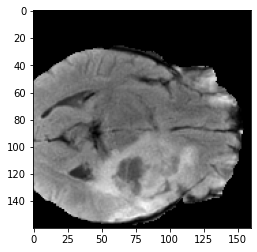

In [23]:
plt.imshow(X[55][0,:,:,12], cmap = 'gray')

Ground truth


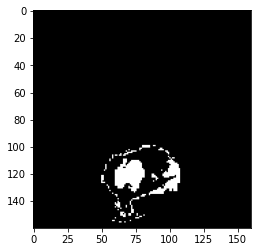

In [28]:
print('Ground truth')
plt.imshow(true_y[1,:,:,12],cmap = 'gray')

Prediction


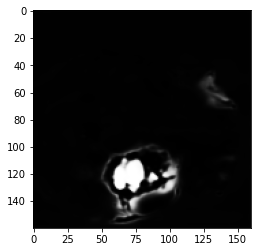

In [29]:
print('Prediction')
plt.imshow(pred_y[1,:,:,12],cmap = 'gray')